
Training LSTM...
Epoch 1/90


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


983/983 ━━━━━━━━━━━━━━━━━━━━ 116s 114ms/step - AUC: 0.6376 - loss: 0.1635 - val_AUC: 0.7606 - val_loss: 0.1240
Epoch 2/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 144s 116ms/step - AUC: 0.7644 - loss: 0.1120 - val_AUC: 0.7829 - val_loss: 0.1209
Epoch 3/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 137s 111ms/step - AUC: 0.8012 - loss: 0.1049 - val_AUC: 0.8002 - val_loss: 0.1195
Epoch 4/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 145s 115ms/step - AUC: 0.8210 - loss: 0.0999 - val_AUC: 0.8113 - val_loss: 0.1176
Epoch 5/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 142s 115ms/step - AUC: 0.8349 - loss: 0.0968 - val_AUC: 0.8093 - val_loss: 0.1185
Epoch 6/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 110s 112ms/step - AUC: 0.8458 - loss: 0.0956 - val_AUC: 0.8006 - val_loss: 0.1212
Epoch 7/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 142s 112ms/step - AUC: 0.8502 - loss: 0.0931 - val_AUC: 0.8050 - val_loss: 0.1193
Epoch 8/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 143s 113ms/step - AUC: 0.8605 - loss: 0.0900 - val_AUC: 0.8027 - val_loss: 0.1199
Epoch 9/90
983/983 ━━━━━━━━━━━━━━━━

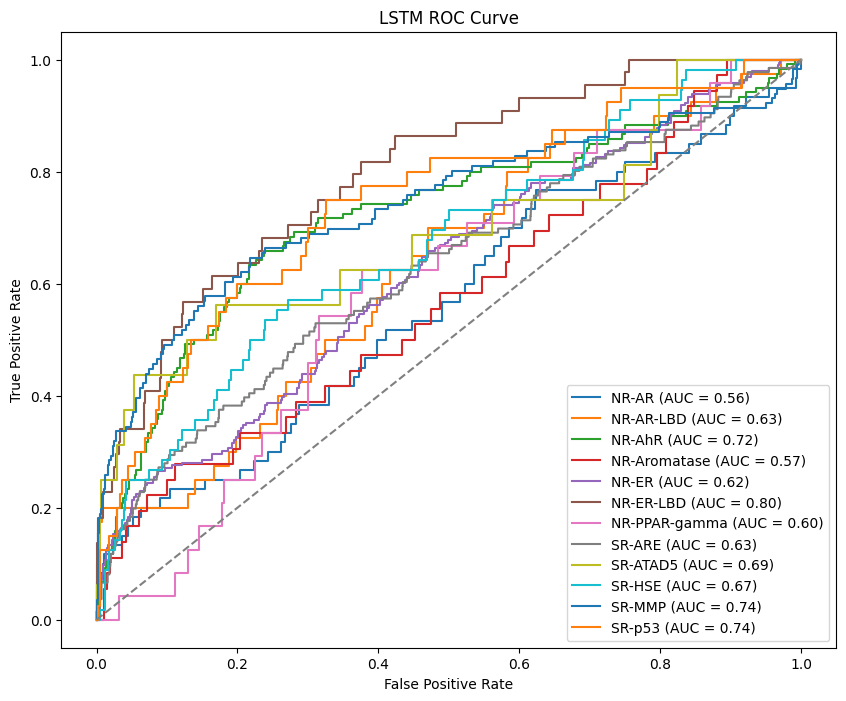


Training BiLSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 220s 218ms/step - AUC: 0.6743 - loss: 0.1486 - val_AUC: 0.7799 - val_loss: 0.1216
Epoch 2/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 259s 215ms/step - AUC: 0.7935 - loss: 0.1056 - val_AUC: 0.7922 - val_loss: 0.1209
Epoch 3/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 264s 218ms/step - AUC: 0.8236 - loss: 0.0986 - val_AUC: 0.7968 - val_loss: 0.1192
Epoch 4/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 261s 216ms/step - AUC: 0.8457 - loss: 0.0968 - val_AUC: 0.7978 - val_loss: 0.1200
Epoch 5/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 261s 215ms/step - AUC: 0.8601 - loss: 0.0924 - val_AUC: 0.8008 - val_loss: 0.1205
Epoch 6/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 264s 218ms/step - AUC: 0.8752 - loss: 0.0902 - val_AUC: 0.7858 - val_loss: 0.1217
Epoch 7/90


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import matplotlib.pyplot as plt
from rdkit import Chem

# === Load Datasets ===
train_df = pd.read_csv("tox21_train.csv")
val_df = pd.read_csv("tox21_val.csv")
test_df = pd.read_csv("tox21_test.csv")

# === Define Targets ===
targets = [
    "NR-AR", "NR-AR-LBD", "NR-AhR", "NR-Aromatase", "NR-ER", "NR-ER-LBD",
    "NR-PPAR-gamma", "SR-ARE", "SR-ATAD5", "SR-HSE", "SR-MMP", "SR-p53"
]

# === SMILES Augmentation Functions ===
def randomize_smiles(smiles, num_aug=5):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []
    return [Chem.MolToSmiles(mol, doRandom=True) for _ in range(num_aug)]

def augment_dataframe(df, label_columns, num_aug=3):
    augmented_rows = []
    for _, row in df.iterrows():
        base_smiles = row['smiles']
        labels = row[label_columns]
        augmented_rows.append({'smiles': base_smiles, **labels.to_dict()})
        for s in randomize_smiles(base_smiles, num_aug=num_aug):
            augmented_rows.append({'smiles': s, **labels.to_dict()})
    return pd.DataFrame(augmented_rows)

# === Preprocess Each Set ===
train_df = train_df.dropna(subset=["smiles"] + targets)
val_df = val_df.dropna(subset=["smiles"] + targets)
test_df = test_df.dropna(subset=["smiles"] + targets)

# Apply augmentation to training set
train_df = augment_dataframe(train_df, targets, num_aug=3)

# Tokenizer (fit only on augmented training set)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_df["smiles"].astype(str))

def preprocess(df, tokenizer, maxlen=200):
    sequences = tokenizer.texts_to_sequences(df["smiles"].astype(str))
    X = pad_sequences(sequences, maxlen=maxlen)
    Y = df[targets].astype(int).values
    return X, Y

X_train, Y_train = preprocess(train_df, tokenizer)
X_val, Y_val = preprocess(val_df, tokenizer)
X_test, Y_test = preprocess(test_df, tokenizer)
vocab_size = len(tokenizer.word_index) + 1

# === ROC Plot ===
def plot_roc_curve(y_true, y_pred, name):
    plt.figure(figsize=(10, 8))
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{targets[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# === Model Evaluation ===
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    aucs = []
    for i in range(Y_test.shape[1]):
        try:
            auc_score = roc_auc_score(Y_test[:, i], y_pred[:, i])
        except ValueError:
            auc_score = np.nan
        aucs.append(auc_score)
    print(f"\n{name} ROC-AUCs:")
    for i, target in enumerate(targets):
        print(f"{target:15s}: ROC-AUC = {aucs[i]:.3f}")
    plot_roc_curve(Y_test, y_pred, name)
    return aucs

# === Model Builders ===
def build_lstm():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=200),
        LSTM(64),
        Dropout(0.3),
        Dense(12, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
    return model

def build_bilstm():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=200),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(12, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
    return model

def build_cnn():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=200),
        Conv1D(128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(12, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
    return model

# === Train & Evaluate Each Model ===
for name, builder in [("LSTM", build_lstm), ("BiLSTM", build_bilstm), ("1D-CNN", build_cnn)]:
    print(f"\nTraining {name}...")
    model = builder()
    model.fit(X_train, Y_train, epochs=90, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
    evaluate_model(model, name)
